In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


In [2]:
import warnings
from collections import Counter
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_log_error, accuracy_score
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')
%matplotlib inline

In [3]:
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
sample = pd.read_csv('../input/tmdb-box-office-prediction/sample_submission.csv')
test_id = test['id']
target = train['revenue']

In [4]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
test.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [6]:
sample.head()

,id,revenue
0,3001,1000000
1,3002,1000000
2,3003,1000000
3,3004,1000000
4,3005,1000000


In [7]:
train.shape, test.shape

((3000, 23), (4398, 22))

# EDA 

# Belongs To Collection

In [8]:
for i in range(10):
    print(train['belongs_to_collection'][i])

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
nan
nan
nan
nan
nan
nan
[{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]
nan


In [9]:
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [10]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [11]:
train.drop(['belongs_to_collection'], axis=1, inplace=True)
test.drop(['belongs_to_collection'], axis=1, inplace=True)

# Genres

In [12]:
for i in range(10):
    print(train['genres'][i])

[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]
[{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}]
[{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]
[{'id': 99, 'name': 'Documentary'}]
[{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10751, 'name': 'Family'}, {'id': 12, 'name': 'Adventure'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}]


### We Should just extract the useful info (in this case we just need the genre of the movie)

In [13]:
print(train.iloc[1, :])

id                                                                      2
budget                                                           40000000
genres                  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
homepage                                                              NaN
imdb_id                                                         tt0368933
original_language                                                      en
original_title                   The Princess Diaries 2: Royal Engagement
overview                Mia Thermopolis is now a college graduate and ...
popularity                                                        8.24889
poster_path                              /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
production_companies          [{'name': 'Walt Disney Pictures', 'id': 2}]
production_countries    [{'iso_3166_1': 'US', 'name': 'United States o...
release_date                                                       8/6/04
runtime                               

In [14]:
def get_dict(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [15]:
gn = pd.DataFrame(columns=['genre_name'])
gn

,genre_name


In [16]:
trainData = pd.concat([train, gn], axis=1)
trainData.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,genre_name
0,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,NaN
1,2,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,NaN
2,3,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,NaN
3,4,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,NaN
4,5,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,NaN


In [17]:
test = pd.concat([test, gn], axis=1)
test.head()

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,genre_name
0,3001,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",NaN
1,3002,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",NaN
2,3003,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",NaN
3,3004,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de...",NaN
4,3005,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...",NaN


In [18]:
j = 0
for i in train['genres']:
    d = get_dict(i)
    if d != {}:
        train['genre_name'][j] = d[0]['name'] 
    else:
         train['genre_name'][j] = np.NaN
    j += 1

j = 0
for i in test['genres']:
    d = get_dict(i)
    if d != {}:
        test['genre_name'][j] = d[0]['name'] 
    else:
         test['genre_name'][j] = np.NaN
    j += 1

In [19]:
train.drop(['genres'], axis=1, inplace=True)
test.drop(['genres'], axis=1, inplace=True)

# Budget

In [20]:
train['budget'].unique()

array([ 14000000,  40000000,   3300000,   1200000,         0,   8000000,
         6000000,   1000000,  15000000,  53000000, 102000000,    500000,
        26000000,  32000000,  80000000,   4000000,  10000000,  11000000,
        45000000,  13000000,  90000000, 140000000,  30000000,  50000000,
         3800000,   3000000,  25000000,   3906840,  44000000,  38000000,
          560000,  12000000,  20000000, 125000000, 150000000,   5000000,
         1500000,   2000000,  85000000,  29000000,    445000,  17000000,
        10284523,  43000000,  28000000,   7500000,  35000000,   2500000,
        10500000,   7000000,  60000000,  10900000,  31000000,  72000000,
        75000000, 100000000,  93000000,  12716953,  18000000,   2400000,
        65000000,   9000000, 110000000,  14320000,   3500000,  39200000,
        63600000,    125000,  19000000,  12468389,  82500000,    259000,
       180000000,   4500000,  24000000,  12600000,  55000000,   3200000,
        22000000,   6700000,   2600000,  49000000, 

## Zeros in budget mean unknown, we will treat it as missing values later

In [21]:
train[train['budget'] == 0].shape[0]

812

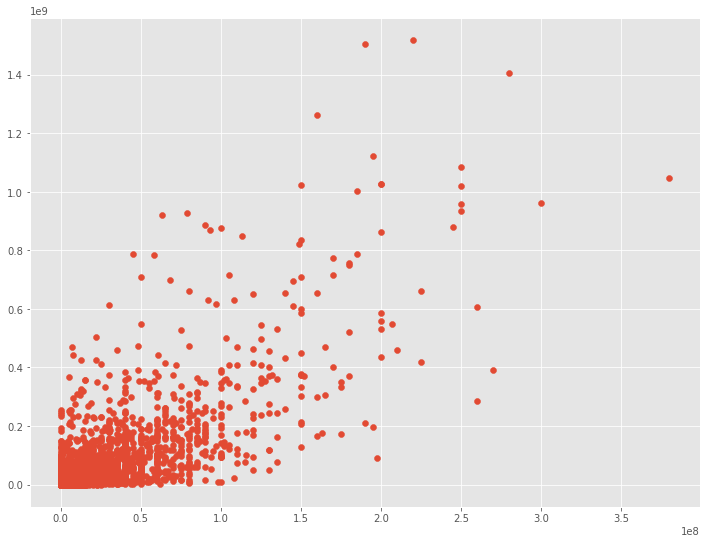

In [22]:
plt.subplots(figsize=(12, 9))
plt.scatter(x=train['budget'], y=train['revenue'])

# Homepage

In [23]:
train['homepage'].value_counts(dropna=False)

NaN                                                   2054
http://www.transformersmovie.com/                        4
http://www.lordoftherings.net/                           2
http://www.thehobbit.com/                                2
http://www.focusfeatures.com/i_am_ali                    1
                                                      ... 
http://www.case39movie.com/mainsite/                     1
http://www.thebountyhunter-movie.net/                    1
http://www.stayinyourroom.com/                           1
http://www.norway-mori.com/index.html                    1
http://www.sonypictures.com/homevideo/freedomland/       1
Name: homepage, Length: 942, dtype: int64

In [24]:
has_hompage = pd.DataFrame(columns=['has_homepage'])

In [25]:
train = pd.concat([train, has_hompage], axis=1)
test = pd.concat([test, has_hompage], axis=1)

In [26]:
j = 0
for i in train['homepage']:
    if str(train['homepage'][j]) == 'nan':
        train['has_homepage'][j] = 0
    else:
        train['has_homepage'][j] = 1
    j += 1

j = 0
for i in test['homepage']:
    if str(test['homepage'][j]) == 'nan':
        test['has_homepage'][j] = 0
    else:
        test['has_homepage'][j] = 1
    j += 1

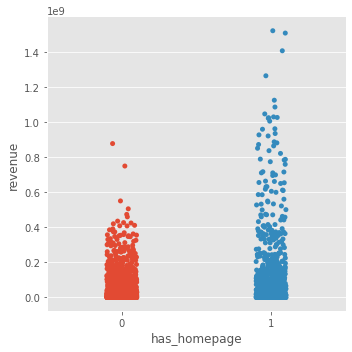

In [27]:
sns.catplot(x='has_homepage', y='revenue', data=train)

## The scatter plot above seems interesting, this really shows that having a wepage for the movie is really affects its revenue

In [28]:
train.drop(['homepage'], axis=1, inplace=True)
test.drop(['homepage'], axis=1, inplace=True)
train.shape, test.shape

((3000, 22), (4398, 21))

# Imdb Id

In [29]:
train['imdb_id']

0       tt2637294
1       tt0368933
2       tt2582802
3       tt1821480
4       tt1380152
          ...    
2995    tt0109403
2996    tt2364975
2997    tt0116908
2998    tt0343135
2999    tt1600195
Name: imdb_id, Length: 3000, dtype: object

In [30]:
train.drop(['imdb_id'], axis=1, inplace=True)
test.drop(['imdb_id'], axis=1, inplace=True)
train.shape, test.shape

((3000, 21), (4398, 20))

# Original Language

In [31]:
print(len(train['original_language'].value_counts(dropna=False)))
train['original_language'].value_counts(dropna=False)

36


en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
nl       6
pt       6
fa       5
da       5
ro       4
tr       3
hu       3
no       2
pl       2
fi       2
ml       2
te       2
he       1
mr       1
el       1
nb       1
cs       1
sr       1
id       1
bn       1
ar       1
vi       1
ur       1
Name: original_language, dtype: int64

In [32]:
print(len(test['original_language'].value_counts(dropna=False)))
test['original_language'].value_counts(dropna=False)

39


en    3776
fr     121
hi      76
ru      62
ja      53
es      52
it      32
de      31
ko      29
zh      27
cn      21
ta      15
da      12
sv      12
ml      10
pt       7
te       7
tr       6
nl       5
ro       5
he       5
th       5
pl       3
no       3
bm       2
fi       2
xx       2
id       2
bn       2
cs       2
el       2
sr       2
af       1
ka       1
is       1
ca       1
kn       1
hu       1
ur       1
Name: original_language, dtype: int64

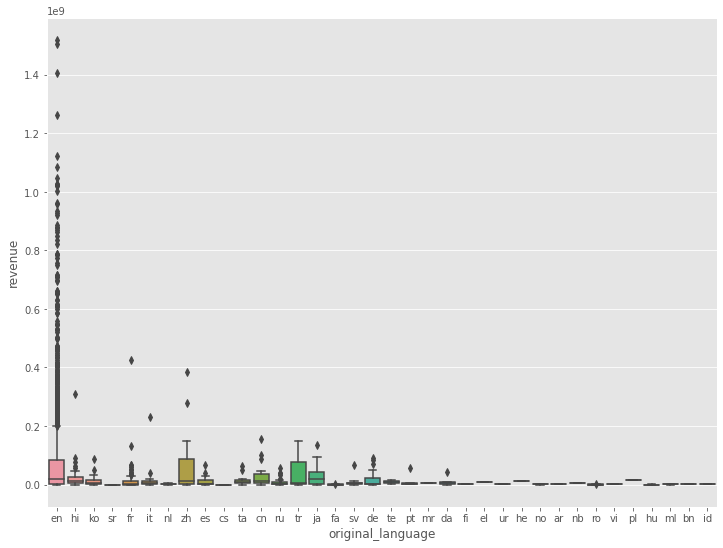

In [33]:
plt.subplots(figsize=(12, 9))
sns.boxplot(x=train['original_language'], y=train['revenue'])

## It would be great to make a new feature (Is Original Language is English)

In [34]:
isOrgEn = pd.DataFrame(columns=['is_en_original_language'])
train = pd.concat([train, isOrgEn], axis=1)
test = pd.concat([test, isOrgEn], axis=1)

print(train['original_language'][0])

en


In [35]:
j = 0
for i in train['original_language']:
    if i == 'en':
        train['is_en_original_language'][j] = 1
    else:
        train['is_en_original_language'][j] = 0
    j += 1
    
j = 0
for i in test['original_language']:
    if i == 'en':
        test['is_en_original_language'][j] = 1
    else:
        test['is_en_original_language'][j] = 0
    j += 1

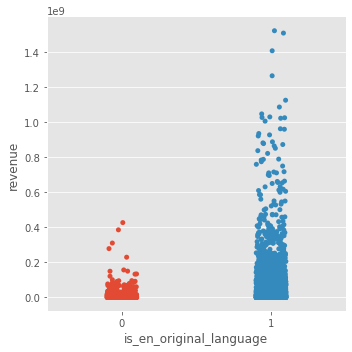

In [36]:
sns.catplot(x='is_en_original_language', y='revenue', data=train)

### The feature we generated is great indeed

# Original Title

In [37]:
len(train['original_title'].value_counts())

2975

In [38]:
train.drop(['original_title'], axis=1, inplace=True)
test.drop(['original_title'], axis=1, inplace=True)

# Overview

In [39]:
for i in range(5): 
    print(train['overview'][i])
    print("--------------------")

When Lou, who has become the "father of the Internet," is shot by an unknown assailant, Jacob and Nick fire up the time machine again to save their friend.
--------------------
Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as princess. Her best friend Lilly also joins her for the summer. Mia continues her 'princess lessons'- riding horses side-saddle, archery, and other royal. But her complicated life is turned upside down once again when she not only learns that she is to take the crown as queen earlier than expected...
--------------------
Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity.
--------------------
Vidya Bagchi (Vidya Balan) arrives in Kolkata from London to find her missing husband Arnab Bagchi. Seven months pregnant and alone in a festive city, she begins a relentless search for her husband. With nothing to rely on except fragments from her memorie

### I don't think using overview is gonna help us

In [40]:
train.drop(['overview'], axis=1, inplace=True)
test.drop(['overview'], axis=1, inplace=True)
train.shape, test.shape

((3000, 20), (4398, 19))

In [41]:
# Popularity 

In [42]:
train['popularity'].unique()

array([ 6.575393,  8.248895, 64.29999 , ..., 14.482345, 15.725542,
       10.512109])

In [43]:
train['popularity'].isnull().sum()

0

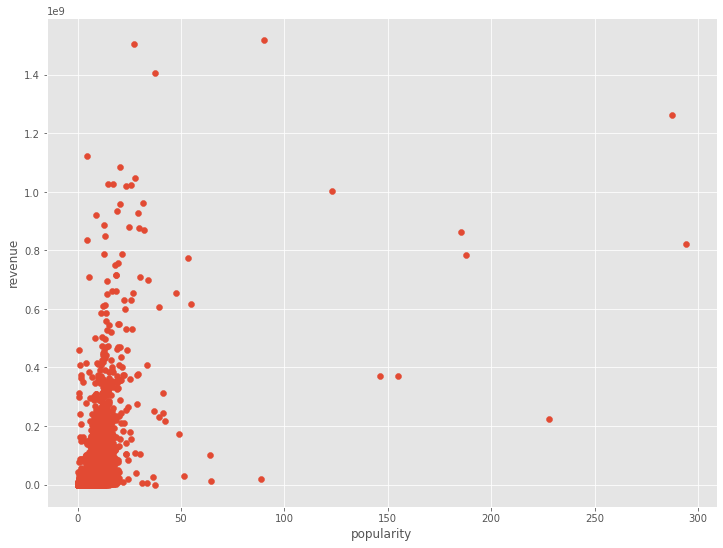

In [44]:
plt.subplots(figsize=(12, 9))
# sns.catplot(x='revenue', y='popularity', data=train)
plt.scatter(x=train['popularity'], y=train['revenue'])
plt.xlabel('popularity')
plt.ylabel('revenue')
plt.show()

## This would be useful

# Poster Path

In [45]:
train.drop(['poster_path'], axis=1, inplace=True)
test.drop(['poster_path'], axis=1, inplace=True)
train.shape, test.shape

((3000, 19), (4398, 18))

# Production Companies

In [46]:
for i in range(5):
    print(train['production_companies'][i])
    print("-------")

[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
-------
[{'name': 'Walt Disney Pictures', 'id': 2}]
-------
[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
-------
nan
-------
nan
-------


### Most of films have 1-2 production companies, cometimes 3-4. But there are films with 10+ companies! Let's have a look at some of them.
### Not sure yet what i'm gonna do with these data

## I guess my best move for now to get the number of production companies, The most 50 common production companies

# Number of prod companies

In [47]:
num_prod_com = pd.DataFrame(columns=['num_production_companies'])
train = pd.concat([train, num_prod_com], axis=1)
test = pd.concat([test, num_prod_com], axis=1)

In [48]:
d = get_dict(train['production_companies'][0])
# This has 3 production companies
print(len(d))
d

3


[{'name': 'Paramount Pictures', 'id': 4},
 {'name': 'United Artists', 'id': 60},
 {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]

In [49]:
j = 0
for i in train['production_companies']:
    d = get_dict(i)
    if len(d) != 0:
        train['num_production_companies'][j] = len(d)
    else:
        train['num_production_companies'][j] = np.NaN
    j += 1

j = 0
for i in test['production_companies']:
    d = get_dict(i)
    if len(d) != 0:
        test['num_production_companies'][j] = len(d)
    else:
        test['num_production_companies'][j] = np.NaN
    j += 1

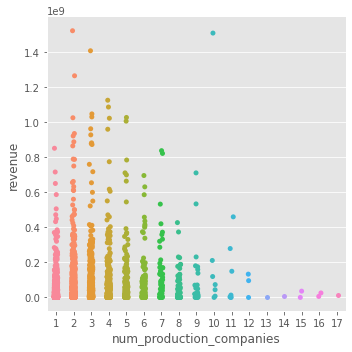

In [50]:
sns.catplot(x='num_production_companies', y='revenue', data=train)

# Production Company

In [51]:
list_of_companies = []
for i in train['production_companies']:
    d = get_dict(i)
    if d != {}:
        for j in range(len(d)):
            list_of_companies.append(d[j]['name'])
list_of_companies

['Paramount Pictures',
 'United Artists',
 'Metro-Goldwyn-Mayer (MGM)',
 'Walt Disney Pictures',
 'Bold Films',
 'Blumhouse Productions',
 'Right of Way Films',
 'Ghost House Pictures',
 'North Box Productions',
 'Walt Disney Pictures',
 'Jim Henson Productions',
 'Jim Henson Company, The',
 'Castle Rock Entertainment',
 'United Artists',
 'Twentieth Century Fox Film Corporation',
 'Amercent Films',
 'American Entertainment Partners L.P.',
 'Interscope Communications',
 'DreamWorks SKG',
 'Jinks/Cohen Company',
 'Double Feature Films',
 'Jersey Films',
 'Nina Saxon Film Design',
 'Metro-Goldwyn-Mayer (MGM)',
 'DreamWorks SKG',
 'Cruise/Wagner Productions',
 'Amblin Entertainment',
 'Twentieth Century Fox Film Corporation',
 'Blue Tulip Productions',
 'Ronald Shusett/Gary Goldman',
 'Digital Image Associates',
 'Hypnopolis',
 'DreamWorks SKG',
 'Craven-Maddalena Films',
 'BenderSpink',
 'BBC Films',
 'Headline Pictures',
 'Magnolia Mae Films',
 'Taeoo Entertainment',
 'UK Film Council',

In [52]:
# Top 50 production companies
top_companies_cnt = list(Counter(list_of_companies).most_common(50))
top_companies = []
for i in top_companies_cnt:
    top_companies.append(i[0])
temp = 0
for i in top_companies_cnt:
    temp += i[1]
temp

2119

In [53]:
print(top_companies_cnt)

[('Warner Bros.', 202), ('Universal Pictures', 188), ('Paramount Pictures', 161), ('Twentieth Century Fox Film Corporation', 138), ('Columbia Pictures', 91), ('Metro-Goldwyn-Mayer (MGM)', 84), ('New Line Cinema', 75), ('Touchstone Pictures', 63), ('Walt Disney Pictures', 62), ('Columbia Pictures Corporation', 61), ('TriStar Pictures', 53), ('Relativity Media', 48), ('Canal+', 46), ('United Artists', 44), ('Miramax Films', 40), ('Village Roadshow Pictures', 36), ('Regency Enterprises', 31), ('BBC Films', 30), ('Dune Entertainment', 30), ('Working Title Films', 30), ('Fox Searchlight Pictures', 29), ('StudioCanal', 28), ('Lionsgate', 28), ('DreamWorks SKG', 27), ('Fox 2000 Pictures', 25), ('Summit Entertainment', 24), ('Hollywood Pictures', 24), ('Orion Pictures', 24), ('Amblin Entertainment', 23), ('Dimension Films', 23), ('Castle Rock Entertainment', 21), ('Epsilon Motion Pictures', 21), ('Morgan Creek Productions', 21), ('Original Film', 21), ('Focus Features', 21), ('Legendary Pictur

In [54]:
print(top_companies)

['Warner Bros.', 'Universal Pictures', 'Paramount Pictures', 'Twentieth Century Fox Film Corporation', 'Columbia Pictures', 'Metro-Goldwyn-Mayer (MGM)', 'New Line Cinema', 'Touchstone Pictures', 'Walt Disney Pictures', 'Columbia Pictures Corporation', 'TriStar Pictures', 'Relativity Media', 'Canal+', 'United Artists', 'Miramax Films', 'Village Roadshow Pictures', 'Regency Enterprises', 'BBC Films', 'Dune Entertainment', 'Working Title Films', 'Fox Searchlight Pictures', 'StudioCanal', 'Lionsgate', 'DreamWorks SKG', 'Fox 2000 Pictures', 'Summit Entertainment', 'Hollywood Pictures', 'Orion Pictures', 'Amblin Entertainment', 'Dimension Films', 'Castle Rock Entertainment', 'Epsilon Motion Pictures', 'Morgan Creek Productions', 'Original Film', 'Focus Features', 'Legendary Pictures', 'Participant Media', 'Blumhouse Productions', 'New Regency Pictures', 'Film4', 'Spyglass Entertainment', 'Imagine Entertainment', 'Screen Gems', 'Millennium Films', 'TSG Entertainment', 'Lakeshore Entertainment

In [55]:
prod_company = pd.DataFrame(columns=['production_company'])
train = pd.concat([train, prod_company], axis=1)
test = pd.concat([test, prod_company], axis=1)

In [56]:
j = 0
cnt = 0
chk = False
for i in train['production_companies']:
    d = get_dict(i)
#     print(len(d))
    if d != {}:
        if len(d) > 1:
            for k in range(len(d)):
                company_name = d[k]['name']
                if company_name in top_companies:
                    train['production_company'][j] = company_name
                    cnt += 1
                    chk = True
                    break
            
            if chk is False:
                    train['production_company'][j] = d[0]['name']
                
        else:
            train['production_company'][j] = d[0]['name']
    else:
        train['production_company'][j] = np.NaN
    j += 1

print("THE NUMBER OF TOP COMPANIES AT TRAIN:", cnt)

j = 0
cnt = 0
chk = False
for i in test['production_companies']:
    d = get_dict(i)
#     print(len(d))
    if d != {}:
        if len(d) > 1:
            for k in range(len(d)):
                company_name = d[k]['name']
                if company_name in top_companies:
                    test['production_company'][j] = company_name
                    cnt += 1
                    chk = True
                    break
            
            if chk is False:
                    test['production_company'][j] = d[0]['name']
                
        else:
            test['production_company'][j] = d[0]['name']
    else:
        test['production_company'][j] = np.NaN
    j += 1

print("THE NUMBER OF TOP COMPANIES AT TEST:", cnt)

THE NUMBER OF TOP COMPANIES AT TRAIN: 1313
THE NUMBER OF TOP COMPANIES AT TEST: 1869


In [57]:
train['production_company'].value_counts(dropna=False)

NaN                                       912
Universal Pictures                        173
Paramount Pictures                        161
Warner Bros.                              137
Twentieth Century Fox Film Corporation    133
                                         ... 
Enjoy Movies                                1
Vertigo Films                               1
Insurgent Media                             1
Diaphana Films                              1
Apatow Productions                          1
Name: production_company, Length: 421, dtype: int64

## I guess using this column is just useless, we are gonna drop it

In [58]:
train.drop(['production_companies', 'production_company'], axis=1, inplace=True)
test.drop(['production_companies', 'production_company'], axis=1, inplace=True)
train.shape, test.shape

((3000, 19), (4398, 18))

# Production Country

In [59]:
prod_country = pd.DataFrame(columns=['production_country'])
train = pd.concat([train, prod_country], axis=1)
test = pd.concat([test, prod_country], axis=1)

In [60]:
j = 0
for i in train['production_countries']:
    d = get_dict(i)
    if d != {}:
        if len(d) > 1:
            countires = []
            for k in range(len(d)):
                countires.append(d[k]['name'])
            if 'United States of America' in countires:
                train['production_country'][j] = 'United States of America'
        else:
            train['production_country'][j] = d[0]['name']
    else:
        train['production_country'][j] = np.NaN
    j += 1
    
j = 0
for i in test['production_countries']:
    d = get_dict(i)
    if d != {}:
        if len(d) > 1:
            countires = []
            for k in range(len(d)):
                countires.append(d[k]['name'])
            if 'United States of America' in countires:
                test['production_country'][j] = 'United States of America'
        else:
            test['production_country'][j] = d[0]['name']
    else:
        test['production_country'][j] = np.NaN
    j += 1

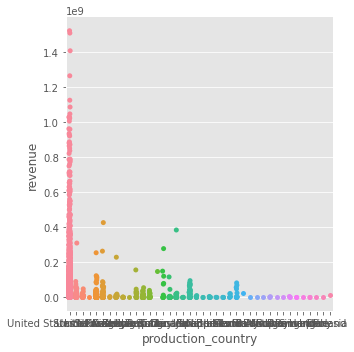

In [61]:
sns.catplot(x='production_country', y='revenue', data=train)

### Some feature like is USA Production sould be useful here, let's see

In [62]:
is_usa_production = pd.DataFrame(columns=['is_usa_production'])
train = pd.concat([train, is_usa_production], axis=1)
test = pd.concat([test, is_usa_production], axis=1)

In [63]:
j = 0
for i in train['production_country']:
    if i == 'United States of America':
        train['is_usa_production'][j] = 1
    elif str(i) == 'nan':
        train['is_usa_production'][j] = np.NaN
    else:
        train['is_usa_production'][j] = 0
    j += 1
    
j = 0
for i in test['production_country']:
    if i == 'United States of America':
        test['is_usa_production'][j] = 1
    elif str(i) == 'nan':
        test['is_usa_production'][j] = np.NaN
    else:
        test['is_usa_production'][j] = 0
    
    j += 1

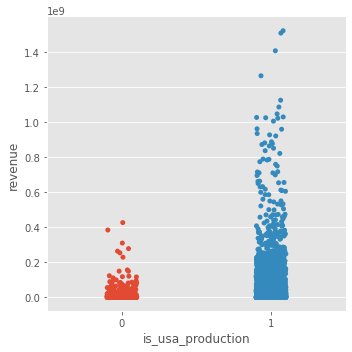

In [64]:
sns.catplot(x='is_usa_production', y='revenue', data=train)

In [65]:
train.drop(['production_countries'], axis=1, inplace=True)
test.drop(['production_countries'], axis=1, inplace=True)

# Release Date

In [66]:
train['release_date'][:5]

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

In [67]:
print(list(train['release_date'][1]))
print(train['release_date'][1])

['8', '/', '6', '/', '0', '4']
8/6/04


# Split the Release date to (Release Day, Release Month, Release Year)

In [68]:
train[['release_month', 'release_day', 'release_year']] = train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
test[['release_month', 'release_day', 'release_year']] = test['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)

In [69]:
train.drop(['release_date'], axis=1, inplace=True)
test.drop(['release_date'], axis=1, inplace=True)
train.shape, test.shape

((3000, 22), (4398, 21))

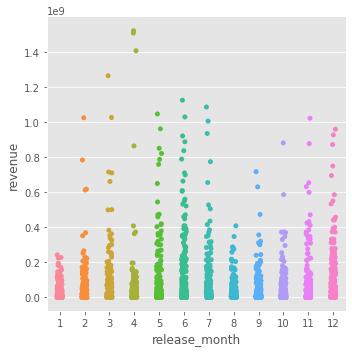

In [70]:
sns.catplot(x='release_month', y='revenue', data=train)

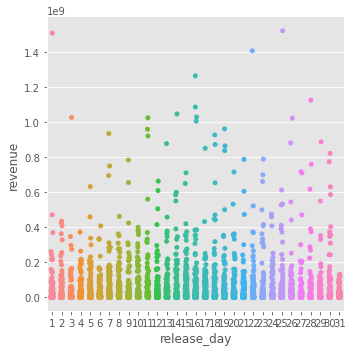

In [71]:
sns.catplot(x='release_day', y='revenue', data=train)

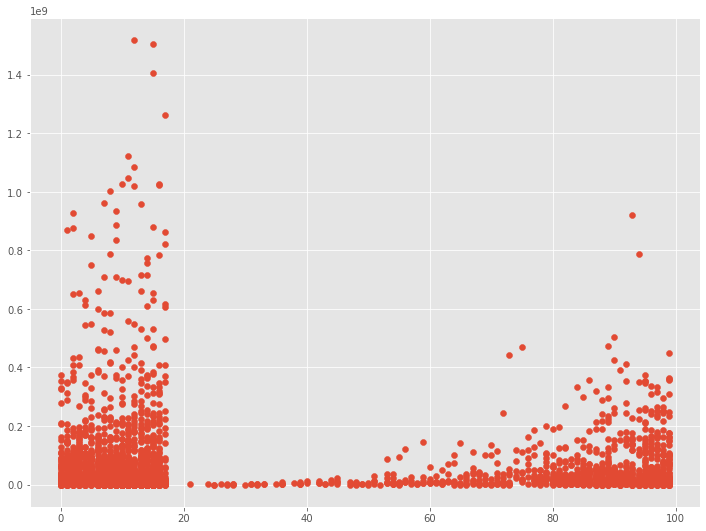

In [72]:
plt.subplots(figsize=(12, 9))
plt.scatter(x=train['release_year'], y=train['revenue'])

# RunTime

In [73]:
print(train['runtime'].isnull().sum())
print(test['runtime'].isnull().sum())

2
4


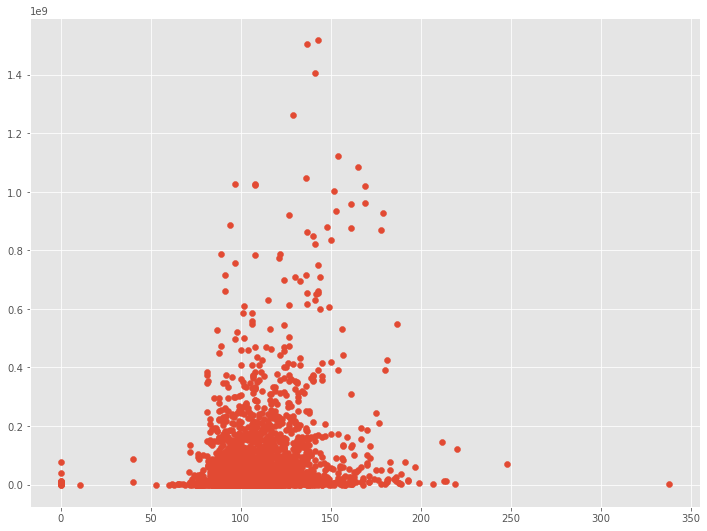

In [74]:
plt.subplots(figsize=(12, 9))
plt.scatter(x=train['runtime'], y=train['revenue'])

In [75]:
# Zero running time means null value
print(len(train[train['runtime'] == 0]))
print(len(train[train['runtime'] == 0]))

12
12


# Spoken Languages

In [76]:
train['spoken_languages'][:5]

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

## Let's generate some features like (how many languages have been spoken in the movie, is English has been spoken)

# Number of Spoken Languages

In [77]:
number_of_spoken_languages = pd.DataFrame(columns=['number_of_spoken_languages'])
train = pd.concat([train, number_of_spoken_languages], axis=1)
test = pd.concat([test, number_of_spoken_languages], axis=1)

In [78]:
j = 0
for i in train['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        train['number_of_spoken_languages'][j] = len(d)
    else:
        train['number_of_spoken_languages'][j] = np.NaN
    j += 1
    
j = 0
for i in test['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        test['number_of_spoken_languages'][j] = len(d)
    else:
        test['number_of_spoken_languages'][j] = np.NaN
    j += 1

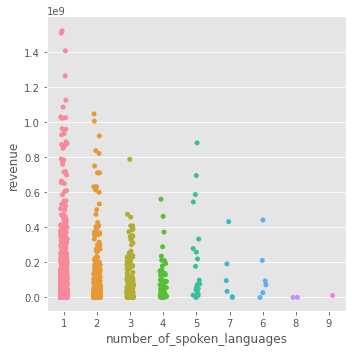

In [79]:
sns.catplot(x='number_of_spoken_languages', y='revenue', data=train)

Clear pattern in the graph above

# Is English a Spoken Language

In [80]:
is_en_spoken = pd.DataFrame(columns=['is_en_spoken'])
train = pd.concat([train, is_en_spoken], axis=1)
test = pd.concat([test, is_en_spoken], axis=1)

In [81]:
j = 0
for i in train['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        langs = []
        for k in range(len(d)):
            lang = d[k]['name']
            langs.append(lang)
        if 'English' in langs:
            train['is_en_spoken'][j] = 1
        else:
            train['is_en_spoken'][j] = 0
    else:
        train['is_en_spoken'][j] = np.NaN
    j += 1
        
j = 0
for i in test['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        langs = []
        for k in range(len(d)):
            lang = d[k]['name']
            langs.append(lang)
        if 'English' in langs:
            test['is_en_spoken'][j] = 1
        else:
            test['is_en_spoken'][j] = 0
    else:
        test['is_en_spoken'][j] = np.NaN
    j += 1

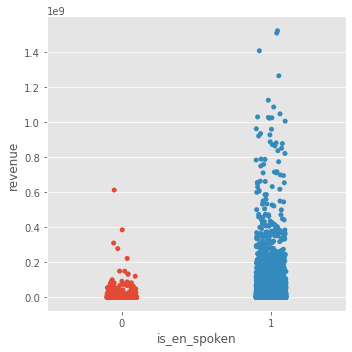

In [82]:
sns.catplot(x='is_en_spoken', y='revenue', data=train)

This feature is really useful

# Spoken Language

In [83]:
spoken_language = pd.DataFrame(columns=['spoken_language'])
train = pd.concat([train, spoken_language], axis=1)
test = pd.concat([test, spoken_language], axis=1)

In [84]:
j = 0
for i in train['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        langs = []
        for k in range(len(d)):
            lang = d[k]['name']
            langs.append(lang)
        if 'English' in langs:
            train['spoken_language'][j] = 'English'
        else:
            train['spoken_language'][j] = langs[0]
    else:
        train['spoken_language'][j] = np.NaN
    j += 1
    
j = 0
for i in test['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        langs = []
        for k in range(len(d)):
            lang = d[k]['name']
            langs.append(lang)
        if 'English' in langs:
            test['spoken_language'][j] = 'English'
        else:
            test['spoken_language'][j] = langs[0]
    else:
        test['spoken_language'][j] = np.NaN
    j += 1

In [85]:
print(len(train['spoken_language'].value_counts()))
print(len(test['spoken_language'].value_counts()))

34
41


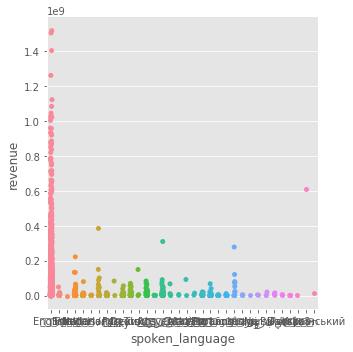

In [86]:
sns.catplot(x='spoken_language', y='revenue', data=train)

In [87]:
train.drop(['spoken_languages'], axis=1, inplace=True)
test.drop(['spoken_languages'], axis=1, inplace=True)
train.shape, test.shape

((3000, 24), (4398, 23))

# Status

In [88]:
print(train['status'].value_counts(dropna=False))
print(test['status'].value_counts(dropna=False))

Released    2996
Rumored        4
Name: status, dtype: int64
Released           4389
Post Production       5
Rumored               2
NaN                   2
Name: status, dtype: int64


# Is Released

In [89]:
is_released = pd.DataFrame(columns=['is_released'])
train = pd.concat([train, is_released], axis=1)
test = pd.concat([test, is_released], axis=1)

In [90]:
j = 0
for i in train['status']:
    if i == 'Released':
        train['is_released'][j] = 1
    else:
        train['is_released'][j] = 0
    j += 1
    
j = 0
for i in test['status']:
    if i == 'Released':
        test['is_released'][j] = 1
    else:
        test['is_released'][j] = 0
    j += 1

In [91]:
print(train['is_released'].value_counts(dropna=False))
print(test['is_released'].value_counts(dropna=False))

1    2996
0       4
Name: is_released, dtype: int64
1    4389
0       9
Name: is_released, dtype: int64


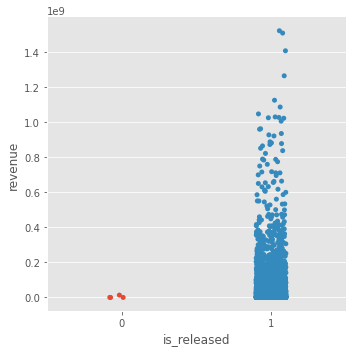

In [92]:
sns.catplot(x='is_released', y='revenue', data=train)

In [93]:
train.drop(['status'], axis=1, inplace=True)
test.drop(['status'], axis=1, inplace=True)
train.shape, test.shape

((3000, 24), (4398, 23))

# Tagline

In [94]:
train['tagline'][:10]

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
5                                                  NaN
6                 Fear The Demon That Doesn't Fear God
7                Different channels. Different truths.
8                          Set sail for Muppet mayhem!
9             Back together for the first time, again.
Name: tagline, dtype: object

In [95]:
train.drop(['tagline'], axis=1, inplace=True)
test.drop(['tagline'], axis=1, inplace=True)
train.shape, test.shape

((3000, 23), (4398, 22))

# Keywords

In [96]:
for i in range(10): 
    print(train['Keywords'][i])
    print("-------")

[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
-------
[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
-------
[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
-------
[{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220

In [97]:
keyword = pd.DataFrame(columns=['keyword'])
train = pd.concat([train, keyword], axis=1)
test = pd.concat([test, keyword], axis=1)

In [98]:
j = 0
for i in train['Keywords']:
    d = get_dict(i)
    if d != {}:
        train['keyword'][j] = d[0]['name']
    else:
        train['keyword'][j] = np.NaN
    j += 1
    
j = 0
for i in test['Keywords']:
    d = get_dict(i)
    if d != {}:
        test['keyword'][j] = d[0]['name']
    else:
        test['keyword'][j] = np.NaN
    j += 1

In [99]:
train['keyword'].value_counts(dropna=False)

NaN                 276
based on novel       56
independent film     42
prison               41
new york             40
                   ... 
homicide              1
computer              1
deer                  1
naivety               1
joke                  1
Name: keyword, Length: 1029, dtype: int64

In [100]:
# We can not handle this much of keywords
train.drop(['Keywords', 'keyword'], axis=1, inplace=True)
test.drop(['Keywords', 'keyword'], axis=1, inplace=True)
train.shape, test.shape

((3000, 22), (4398, 21))

# Cast

In [101]:
for i in range(1):
    print(train['cast'][i])
    print("----------")

[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character'

# Size of cast (number of actors)

In [102]:
size_of_cast = pd.DataFrame(columns=['size_of_cast'])
train = pd.concat([train, size_of_cast], axis=1)
test = pd.concat([test, size_of_cast], axis=1)

In [103]:
j = 0
for i in train['cast']:
    d = get_dict(i)
    if d != {}:
        train['size_of_cast'][j] = len(d)
    else:
        train['size_of_cast'][j] = np.NaN
    j += 1
    
j = 0
for i in test['cast']:
    d = get_dict(i)
    if d != {}:
        test['size_of_cast'][j] = len(d)
    else:
        test['size_of_cast'][j] = np.NaN
    j += 1

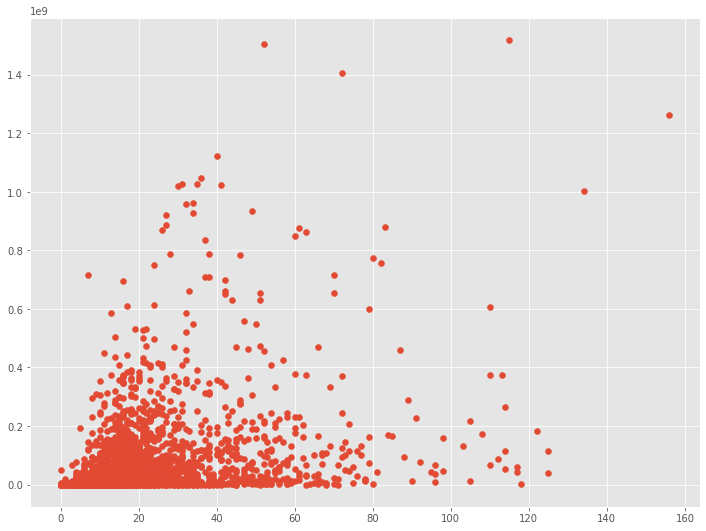

In [104]:
plt.subplots(figsize=(12, 9))
plt.scatter(x=train['size_of_cast'], y=train['revenue'])

In [105]:
train.drop(['cast'], axis=1, inplace=True)
test.drop(['cast'], axis=1, inplace=True)
train.shape, test.shape

((3000, 22), (4398, 21))

# Title, Crew

In [106]:
train.drop(['id', 'crew', 'title'], axis=1, inplace=True)
test.drop(['id', 'crew', 'title'], axis=1, inplace=True)
train.shape, test.shape

((3000, 19), (4398, 18))

# Null values

### Budget

In [107]:
print(train['budget'].isnull().sum())
print(test['budget'].isnull().sum())
print(len(train[train['budget'] == 0]))
print(len(test[test['budget'] == 0]))

0
0
812
1211


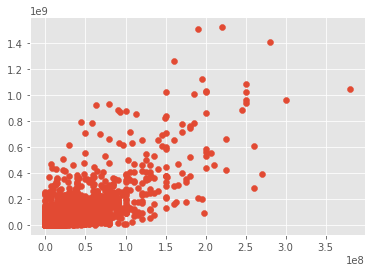

In [108]:
plt.scatter(x=train['budget'], y=train['revenue'])

In [109]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test], axis=0)
train.shape, test.shape, all_data.shape

((3000, 19), (4398, 18), (7398, 19))

In [110]:
all_data['budget'].dtype

dtype('int64')

In [111]:
all_data['budget'] = all_data['budget'].replace(0, all_data['budget'].mean())

### Original Language

In [112]:
print(all_data['original_language'].isnull().sum())
print(len(all_data[all_data['original_language'] == 0]))

0
0


### Popularity

In [113]:
print(all_data['popularity'].isnull().sum())
print(len(all_data[all_data['popularity'] == 0]))

0
0


### Runtime

In [114]:
print(all_data['runtime'].isnull().sum())
print(len(all_data[all_data['runtime'] == 0]))

6
21


In [115]:
all_data['runtime'].mean()

107.7172619047619

In [116]:
all_data['runtime'] = all_data['runtime'].replace(0, all_data['runtime'].mean())
all_data['runtime'] = all_data['runtime'].fillna(all_data['runtime'].mean())

### Genre Name

In [117]:
print(all_data['genre_name'].isnull().sum())
print(len(all_data[all_data['genre_name'] == 0]))

23
0


In [118]:
print(all_data['genre_name'].value_counts())

Drama              1934
Comedy             1568
Action             1195
Adventure           474
Horror              403
Crime               333
Thriller            259
Animation           188
Documentary         188
Fantasy             182
Romance             176
Science Fiction     116
Mystery              91
Family               79
War                  50
Music                49
Western              44
History              39
Foreign               6
TV Movie              1
Name: genre_name, dtype: int64


In [119]:
all_data['genre_name'] = all_data['genre_name'].fillna(all_data['genre_name'].mode()[0])

### Number of production companies

In [120]:
print(all_data['num_production_companies'].isnull().sum())
print(len(all_data[all_data['num_production_companies'] == 0]))

414
0


In [121]:
all_data['num_production_companies'] = all_data['num_production_companies'].fillna(all_data['num_production_companies'].mean().round())

In [122]:
train.head()

,budget,original_language,popularity,runtime,revenue,genre_name,has_homepage,is_en_original_language,num_production_companies,production_country,is_usa_production,release_month,release_day,release_year,number_of_spoken_languages,is_en_spoken,spoken_language,is_released,size_of_cast
0,14000000,en,6.575393,93.0,12314651,Comedy,0,1,3,United States of America,1,2,20,15,1,1,English,1,24
1,40000000,en,8.248895,113.0,95149435,Comedy,0,1,1,United States of America,1,8,6,4,1,1,English,1,20
2,3300000,en,64.299990,105.0,13092000,Drama,1,1,3,United States of America,1,10,10,14,1,1,English,1,51
3,1200000,hi,3.174936,122.0,16000000,Thriller,1,0,NaN,India,0,3,9,12,2,1,English,1,7
4,0,ko,1.148070,118.0,3923970,Action,0,0,NaN,South Korea,0,2,5,9,1,0,한국어/조선말,1,4
